In [1]:
import matplotlib.pyplot
import numpy as np
import pandas as pan
import mpl_toolkits.mplot3d  # noqa: F401
import xgboost as xgb
import pandas as pd
import sklearn as sk
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

df = pan.read_excel('C:/Users/justice/Downloads/FinalDataProject.xlsx', header=0)


print (df.tail(25))
print (len(df))

             Date & Time  A. Rain Gauge (mm)  Fluorescence Increase (RFU)  \
4778 2022-11-27 12:00:00          410.830000                   651.000000   
4779 2022-11-27 13:00:00          411.000000                   651.000000   
4780 2022-11-27 14:00:00          411.000000                   974.460317   
4781 2022-11-27 15:00:00          411.000000                   651.000000   
4782 2022-11-27 16:00:00          411.000000                   651.000000   
4783 2022-11-27 17:00:00          411.000000                   974.460317   
4784 2022-11-27 18:00:00          411.000000                   651.000000   
4785 2022-11-27 19:00:00          411.276667                   651.000000   
4786 2022-11-27 20:00:00          412.820000                   974.460317   
4787 2022-11-27 21:00:00          414.620000                   651.000000   
4788 2022-11-27 22:00:00          416.293333                   651.000000   
4789 2022-11-27 23:00:00          416.606667                   974.460317   

In [2]:
cols = list(df)[1 : 8]

df = df.set_index(pd.to_datetime(df['Date & Time']))

for c in df.columns:
    print("\t" + str(c))

df['Date & Time'] = df['Date & Time'].apply(pd.to_datetime)

df.rename(columns = {'Hourly precipitation amount (in 0.1 mm) (-1 for <0.05 mm)':'Hourly precipitation amount (in 0.1 mm) ()'}, inplace = True)

print(df['Date & Time'])

	Date & Time
	A. Rain Gauge (mm)
	Fluorescence Increase (RFU)
	Net Activity Cycle (pmol)
	Mean wind speed (in 0.1 m/s)
	Temperature (in 0.1 degrees Celsius)
	Precipitation duration (in 0.1 hour)
	Hourly precipitation amount (in 0.1 mm) (-1 for <0.05 mm)
	Rainfall 0=no occurrence / 1=occurred
	Days of Week
Date & Time
2022-05-12 10:00:00   2022-05-12 10:00:00
2022-05-12 11:00:00   2022-05-12 11:00:00
2022-05-12 12:00:00   2022-05-12 12:00:00
2022-05-12 13:00:00   2022-05-12 13:00:00
2022-05-12 14:00:00   2022-05-12 14:00:00
                              ...        
2022-11-28 08:00:00   2022-11-28 08:00:00
2022-11-28 09:00:00   2022-11-28 09:00:00
2022-11-28 10:00:00   2022-11-28 10:00:00
2022-11-28 11:00:00   2022-11-28 11:00:00
2022-11-28 12:00:00   2022-11-28 12:00:00
Name: Date & Time, Length: 4803, dtype: datetime64[ns]


[10:50:08] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-rmse:23.72080	validation_1-rmse:17.55501
[1]	validation_0-rmse:22.07495	validation_1-rmse:16.16590
[2]	validation_0-rmse:20.53573	validation_1-rmse:15.69087
[3]	validation_0-rmse:19.18542	validation_1-rmse:15.29338
[4]	validation_0-rmse:17.79352	validation_1-rmse:15.98807
[5]	validation_0-rmse:16.66913	validation_1-rmse:16.91548
[6]	validation_0-rmse:15.80247	validation_1-rmse:18.17150
[7]	validation_0-rmse:15.04130	validation_1-rmse:19.60243
[8]	validation_0-rmse:14.10529	validation_1-rmse:21.42037
[9]	validation_0-rmse:13.30180	validation_1-rmse:23.48849
[10]	validation_0-rmse:12.65712	validation_1-rmse:25.01457
[11]	validation_0-rmse:12.18796	validation_1-rmse:25.02898
[12]	validation_0-rmse:11.58299	validation_1-rmse:26.85579
[13]	validation_0-rmse:11.27231	validation_1-r

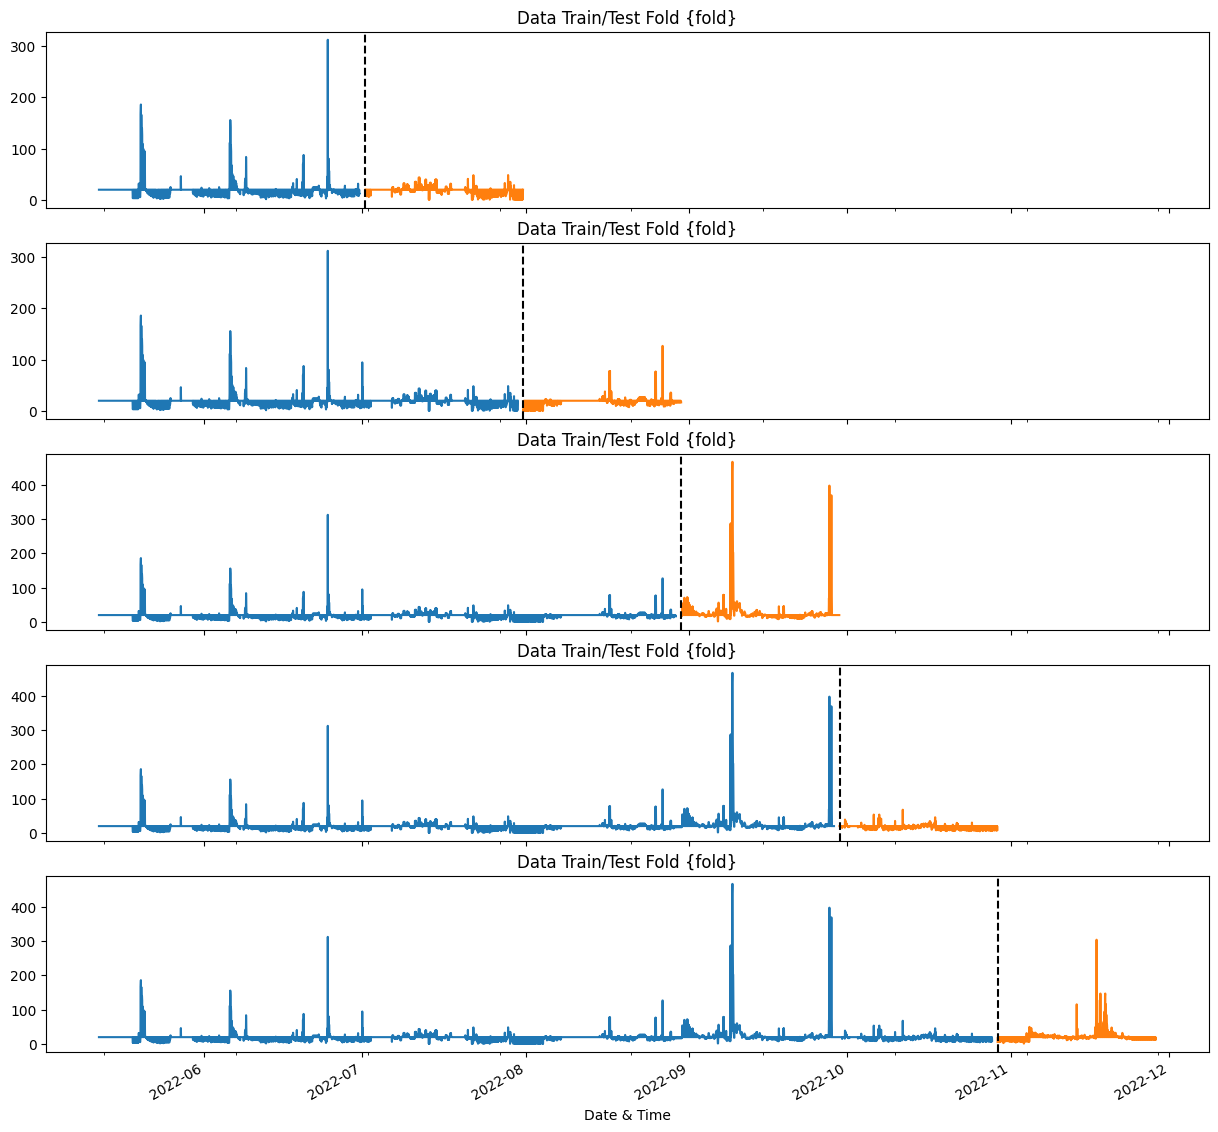

In [3]:
import sklearn as sk
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb

tes = TimeSeriesSplit(n_splits=5, test_size=24*30*1, gap=24)
df = df.sort_index()

fig, ax3 = matplotlib.pyplot.subplots(5, 1, figsize=(15, 15), sharex=True)

def add_lags(df):
    df['lag1'] = df['Net Activity Cycle (pmol)'].shift(6)
    df['lag2'] = df['Net Activity Cycle (pmol)'].shift(12)
    df['lag3'] = df['Net Activity Cycle (pmol)'].shift(24)
    return df

df = add_lags(df)

preds = []
fold = 0

for train_index, val_index in tes.split(df):
    train = df.iloc[train_index]
    test = df.iloc[val_index]

    df['hour'] = df.index.hour
    df['day of week'] = df.index.dayofweek

    features = ['Mean wind speed (in 0.1 m/s)', 'Temperature (in 0.1 degrees Celsius)',
                'Precipitation duration (in 0.1 hour)', 'Hourly precipitation amount (in 0.1 mm) ()',
                'Rainfall 0=no occurrence / 1=occurred', 'Fluorescence Increase (RFU)', 'A. Rain Gauge (mm)']
    target = 'Net Activity Cycle (pmol)'

    x_train = train[features]
    y_train = train[target]

    x_test = test[features]
    y_test = test[target]

    #Training & Validation
    model = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, verbose=100, learning_rate=0.1 ,colsample_bytree=0.8,
gamma=2)
    model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)])

    #Actual Predictions
    pred = model.predict(x_test)
    preds.append(pred)
    score = np.sqrt(mean_squared_error(test['Net Activity Cycle (pmol)'], pred))
    print(f'Mean squared error = {score}')
    predictions = [round(value) for value in pred]
    tester =  [round(value) for value in y_test]
    accuracy = accuracy_score(tester, predictions)
    print(f'Accu = {accuracy}')

    train['Net Activity Cycle (pmol)'].plot(ax=ax3[fold], label='Training', title='Data Train/Test Fold {fold}')
    test['Net Activity Cycle (pmol)'].plot(ax=ax3[fold], label='Testing')
    ax3[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1

matplotlib.pyplot.show()


AxesSubplot(0.125,0.2;0.775x0.68)
AxesSubplot(0.125,0.2;0.775x0.68)


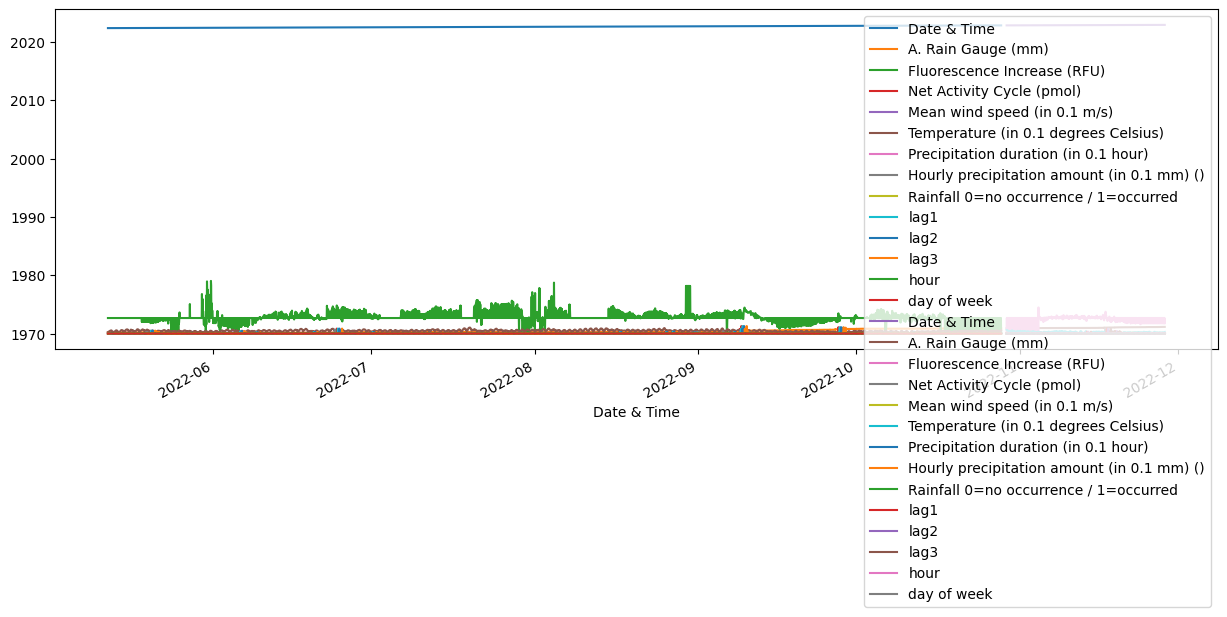

                                            importance
Mean wind speed (in 0.1 m/s)                  0.064001
Temperature (in 0.1 degrees Celsius)          0.074788
Precipitation duration (in 0.1 hour)          0.140385
Hourly precipitation amount (in 0.1 mm) ()    0.077432
Rainfall 0=no occurrence / 1=occurred         0.130298
Fluorescence Increase (RFU)                   0.134763
A. Rain Gauge (mm)                            0.378334


In [4]:
fig, ax = matplotlib.pyplot.subplots(figsize=(15, 5))
print (train.plot(ax=ax))
print (test.plot(ax=ax))

matplotlib.pyplot.show()

importance_col = pan.DataFrame(model.feature_importances_, index=model.feature_names_in_, columns=['importance'])

print(importance_col)


In [5]:
#Retrain

features = ['Mean wind speed (in 0.1 m/s)', 'Temperature (in 0.1 degrees Celsius)',
            'Precipitation duration (in 0.1 hour)', 'Hourly precipitation amount (in 0.1 mm) ()',
            'Rainfall 0=no occurrence / 1=occurred', 'Fluorescence Increase (RFU)', 'A. Rain Gauge (mm)', 'lag1', 'lag2', 'lag3']
target = 'Net Activity Cycle (pmol)'

x_all = df[features]
y_all = df[target]

model= xgb.XGBRegressor(base_score=0.5,booster='gbtree',n_estimators=110,objective='reg:linear',colsample_bytree= 0.8,
gamma=1.5, max_depth=3,learning_rate=0.01)

model.fit(x_all, y_all, eval_set=[(x_all, y_all)], verbose=100)



[10:50:41] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:28.54525
[100]	validation_0-rmse:19.89646
[109]	validation_0-rmse:19.55119


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=1.5, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=3, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=110, n_jobs=0,
             num_parallel_tree=1, objective='reg:linear', predictor='auto', ...)

In [12]:
datewindow = pan.date_range('2022-11-28 12:00:00', '2022-12-01 1:00:00', freq='1h')
future_df = pan.DataFrame(index=datewindow)
future_df['is_future'] = True
df['is_future'] = False

complete_df = pan.concat([df, future_df])

complete_df = add_lags(complete_df)

future_wFeats = complete_df.query('is_future').copy()

In [17]:
#predict future

print('Checking future set')
print(future_wFeats[['lag1', 'lag2', 'lag3']].head(50))

df['predictions'] = model.predict(x_all)




for c in df.columns:
    print("\t" + str(c))

print(df.head(500))



Checking future set
                          lag1       lag2       lag3
2022-11-28 12:00:00  12.700000  12.700000  12.700000
2022-11-28 13:00:00  19.446808  19.446808  12.700000
2022-11-28 14:00:00  12.700000  12.700000  19.446808
2022-11-28 15:00:00  12.700000  12.700000  12.700000
2022-11-28 16:00:00  19.446808  19.446808  12.700000
2022-11-28 17:00:00  12.700000  12.700000  19.446808
2022-11-28 18:00:00        NaN  12.700000  12.700000
2022-11-28 19:00:00        NaN  19.446808  12.700000
2022-11-28 20:00:00        NaN  12.700000  19.446808
2022-11-28 21:00:00        NaN  12.700000  12.700000
2022-11-28 22:00:00        NaN  19.446808  12.700000
2022-11-28 23:00:00        NaN  12.700000  19.446808
2022-11-29 00:00:00        NaN        NaN  12.700000
2022-11-29 01:00:00        NaN        NaN  19.446808
2022-11-29 02:00:00        NaN        NaN  12.700000
2022-11-29 03:00:00        NaN        NaN  12.700000
2022-11-29 04:00:00        NaN        NaN  19.446808
2022-11-29 05:00:00       